<a href="https://colab.research.google.com/github/Gilf641/EVA4/blob/master/S15/OfficeDataset_ImageSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Hardware Properties**

In [1]:
import torch
from IPython.display import Image, clear_output 
import time as t

print('PyTorch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

PyTorch 1.5.1+cu101 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)


**Mount the Drive**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


**Unzip the File**

In [3]:
import zipfile
def zip_data(zipfile, path_to_zipfile, directory_to_extract):
  with zipfile.ZipFile(path_to_zipfile, 'r') as zip:
    zip.extractall(directory_to_extract)
  print("Zipfile extracted to ", directory_to_extract)

# zipfile = "/content/drive/My Drive/DepthEstimation/TestZip.zip"

path_to_zipfile = "/content/drive/My Drive/ZipFiles/data_TenK.zip"
directory_to_extract = "/content/drive/My Drive/ZipExtract"
zip_data(zipfile, path_to_zipfile, directory_to_extract)

Zipfile extracted to  /content/drive/My Drive/ZipExtract


**Some Basic Checks**

In [4]:
import os
os.listdir("/content/drive/My Drive/ZipExtract/data_TenK")

['BG', 'BG_FG Masks', 'BG_FG', 'DepthMaps']

In [5]:
import os
len(os.listdir("/content/drive/My Drive/ZipExtract/data_TenK/DepthMaps"))

10000

**Set the path for all 4 type of Images**

In [6]:
zip_path = "/content/drive/My Drive/ZipExtract/data_TenK"
subd = os.listdir(zip_path) #Returns sub-directories

bg_path, bgfg_mask_path = os.path.join(zip_path, subd[0]), os.path.join(zip_path, subd[1])
bgfg_path, depthmap_path = os.path.join(zip_path, subd[2]), os.path.join(zip_path, subd[3])


for i in [bg_path, bgfg_mask_path, bgfg_path, depthmap_path]:
  print(i)

/content/drive/My Drive/ZipExtract/data_TenK/BG
/content/drive/My Drive/ZipExtract/data_TenK/BG_FG Masks
/content/drive/My Drive/ZipExtract/data_TenK/BG_FG
/content/drive/My Drive/ZipExtract/data_TenK/DepthMaps


**Image Segmentation File**

In [7]:
# Now the first task is to clip input and output
# This is done since BG has only 100 images while BG_FG has around 400K, but for this I'm using 10K
# Now to do this I've used this snippet below, which will clip in the inputs with it's corresponding ground truth

masks = [mask for mask in os.listdir(bgfg_mask_path)] # Mask Files
bg_idx = [int(m.split('_')[1]) for m in masks] # Background file index

bgfiles = [os.path.join(bg_path, bg) for bg in os.listdir(bg_path)] # all 100 BG Files
bg_files = [os.path.join(bgfg_mask_path, bgfiles[idx-1]) for idx in bg_idx ] # BG Files of Proper index
bg_files

['/content/drive/My Drive/ZipExtract/data_TenK/BG/bg001.jpg',
 '/content/drive/My Drive/ZipExtract/data_TenK/BG/bg001.jpg',
 '/content/drive/My Drive/ZipExtract/data_TenK/BG/bg001.jpg',
 '/content/drive/My Drive/ZipExtract/data_TenK/BG/bg001.jpg',
 '/content/drive/My Drive/ZipExtract/data_TenK/BG/bg001.jpg',
 '/content/drive/My Drive/ZipExtract/data_TenK/BG/bg001.jpg',
 '/content/drive/My Drive/ZipExtract/data_TenK/BG/bg001.jpg',
 '/content/drive/My Drive/ZipExtract/data_TenK/BG/bg001.jpg',
 '/content/drive/My Drive/ZipExtract/data_TenK/BG/bg001.jpg',
 '/content/drive/My Drive/ZipExtract/data_TenK/BG/bg001.jpg',
 '/content/drive/My Drive/ZipExtract/data_TenK/BG/bg001.jpg',
 '/content/drive/My Drive/ZipExtract/data_TenK/BG/bg001.jpg',
 '/content/drive/My Drive/ZipExtract/data_TenK/BG/bg001.jpg',
 '/content/drive/My Drive/ZipExtract/data_TenK/BG/bg001.jpg',
 '/content/drive/My Drive/ZipExtract/data_TenK/BG/bg001.jpg',
 '/content/drive/My Drive/ZipExtract/data_TenK/BG/bg001.jpg',
 '/conte

In [8]:
# bg_files = [os.path.join(bg_path, bg) for bg in os.listdir(bg_path)] # BG Files

# I have zipped both bg and bg_fg as image segmentation input, this is obvious. I don't think I need to explain here

bgfg_mask_files = [os.path.join(bgfg_mask_path, mask) for mask in os.listdir(bgfg_mask_path)] # Mask Files
bgfg_files = [os.path.join(bgfg_path, bgfg) for bgfg in os.listdir(bgfg_path)] # bgfg files
# dpmap_files = [os.path.join(depthmap_path, map) for map in os.listdir(depthmap_path)] #Depth Maps

img_seg = list(zip(bg_files, bgfg_files, bgfg_mask_files))
# # ziplist = list(zip1)
type(img_seg)
img_seg # this is the final data for image segmentations, go and use it

[('/content/drive/My Drive/ZipExtract/data_TenK/BG/bg001.jpg',
  '/content/drive/My Drive/ZipExtract/data_TenK/BG_FG/bg_001_fg_001_001.jpeg',
  '/content/drive/My Drive/ZipExtract/data_TenK/BG_FG Masks/bg_001_fg_001_001.jpeg'),
 ('/content/drive/My Drive/ZipExtract/data_TenK/BG/bg001.jpg',
  '/content/drive/My Drive/ZipExtract/data_TenK/BG_FG/bg_001_fg_001_002.jpeg',
  '/content/drive/My Drive/ZipExtract/data_TenK/BG_FG Masks/bg_001_fg_001_002.jpeg'),
 ('/content/drive/My Drive/ZipExtract/data_TenK/BG/bg001.jpg',
  '/content/drive/My Drive/ZipExtract/data_TenK/BG_FG/bg_001_fg_001_003.jpeg',
  '/content/drive/My Drive/ZipExtract/data_TenK/BG_FG Masks/bg_001_fg_001_003.jpeg'),
 ('/content/drive/My Drive/ZipExtract/data_TenK/BG/bg001.jpg',
  '/content/drive/My Drive/ZipExtract/data_TenK/BG_FG/bg_001_fg_001_004.jpeg',
  '/content/drive/My Drive/ZipExtract/data_TenK/BG_FG Masks/bg_001_fg_001_004.jpeg'),
 ('/content/drive/My Drive/ZipExtract/data_TenK/BG/bg001.jpg',
  '/content/drive/My Driv

**Depth Estimation File**

In [9]:
bgfg_files = [os.path.join(bgfg_path, bgfg) for bgfg in os.listdir(bgfg_path)]
dpmap_files = [os.path.join(depthmap_path, map) for map in os.listdir(depthmap_path)]

dp_est = list(zip(bgfg_files,dpmap_files))
# # # ziplist = list(zip1)
type(zip1)

NameError: ignored

**Check the ZIP File**

In [10]:
a,b,c=zip(*img_seg)

In [15]:
len(a)

10000

**Custom Depth Map Dataset Class**

In [21]:
from torch.utils.data import Dataset, random_split
from PIL import Image
import numpy as np
import torch
import os
import torchvision.transforms as transforms
from tqdm import notebook
import zipfile

print("Libraries Imported...")

overall_start_time = t.time()


class DepthMapDataset(Dataset):
  
  # Image Segmentation Part
  def __init__(self, data, bg_transforms, bgfg_transforms, mask_transforms):
    self.bg_images, self.bgfg_images, self.mask_images = zip(*data) # do the unzipping part
    self.bg_transforms = bg_transforms
    self.bgfg_transforms = bgfg_transforms
    self.mask_transforms = mask_transforms


  def __len__(self):
    """
    returns len of the dataset
    """
    return len(self.bgfg_images)


  def __getitem__(self, idx):
    """
    returns image data & target for the corresponding index
    """
    try:
      bg_image = Image.open(self.bg_images[idx]) # BG Images
      bgfg_image = Image.open(self.bgfg_images[idx]) # BG_FG Images
      mask_image = Image.open(self.mask_images[idx]) # Mask Images
      # depth_map = Image.open(self.depth_maps[idx]) # Depth Images

      bg_image = self.bg_transforms(bg_image)
      bgfg_image = self.bgfg_transforms(bgfg_image)
      mask_image = self.mask_transforms(mask_image)
      
      # depth_map = self.depthmap_transforms(depth_map)



      print("Image Transformed")
      # print(bgfg_image.mode)
      # print(depth_map.mode)
      # print("Took {0} seconds.".format(round(t.time()-start_time, 4)))
      return {"bg": bg_image, "bgfg": bgfg_image, "mask": mask_image} #"depthmap": depth_map} # dict way of returning Depth Map
      re


    except Exception as e:
      print("Image {0} skipped due to {1}".format(self.bgfg_images[idx],e)) # this is only if some images can't be identified by PIL

    


Libraries Imported...


**Albumentation Script**

In [22]:
from torchvision import transforms
import albumentations as A
import albumentations.pytorch as AP
import random
import numpy as np

class AlbumentationTransforms:
  """
  Helper class to create test and train transforms using Albumentations
  """
  def __init__(self, transforms_list=[]):
    transforms_list.append(AP.ToTensor()) # Transform the normalized image to Tensor
    self.transforms = A.Compose(transforms_list)


  def __call__(self, img):
    img = np.array(img) 
    return self.transforms(image=img)['image']

  

**Image Transformations**

In [23]:
import albumentations as A
import albumentations.pytorch as AP
import cv2

# BG Images
bg_mean = (0.5177, 0.5439, 0.5617)
bg_stdev = (0.2344, 0.2286, 0.229)

# FG_BG Images
fgbg_mean = (0.513, 0.536, 0.5546)
fgbg_stdev = (0.2355, 0.2317, 0.2326)

# FG Mask Images
mask_mean = (0.2249, 0.2249, 0.2249)
mask_stdev = (0.4025, 0.4025, 0.4025)

# Depth Maps
dpmap_mean = (0.3045)
dpmap_stdev = (0.1130)

# Used same type of transformations for both Train & Test Data

bg_transform = AlbumentationTransforms([A.Normalize(mean=bg_mean,
                                                std=bg_stdev)])

bgfg_transform = AlbumentationTransforms([A.Normalize(mean=fgbg_mean,
                                              std=fgbg_stdev)])

bgfg_mask_transform = AlbumentationTransforms([A.Normalize(mean=mask_mean,
                                                 std=mask_stdev)])

dpmap_transform = AlbumentationTransforms([A.Normalize(mean=dpmap_mean,
                                                    std=dpmap_stdev)])


# dpmap_transforms = AlbumentationTransforms([A.Normalize(mean=dpmap_mean, 
                                              # std=dpmap_std)])
# train_dataset , test_dataset = DepthMapDataset(splitRatio = 70, test_transforms = test_transform,train_transforms = train_transform)


**DataLoaders**

In [ ]:
!python -c 'import PIL; print( PIL.__version__)'

7.0.0


**Dataloaders**

In [24]:
# Both class and func here do the same job. I'm using function for TinyImageNet.

import torch

class DataLoaders:
  def __init__(self, 
              batch_size=512,
              shuffle=True,
              num_workers=4,
              pin_memory=True,
              seed=1):
    """
    Arguments:-
    batch_size: Number of images to be passed in each batch
    shuffle(boolean):  If True, then shuffling of the dataset takes place
    num_workers(int): Number of processes that generate batches in parallel
    pin_memory(boolean):
    seed: Random Number, this is to maintain the consistency
    """
    use_cuda = torch.cuda.is_available()
    device = torch.device('cuda' if use_cuda else 'cpu')  # set device to cuda

    if use_cuda:
      torch.manual_seed(seed)
    
    self.dataLoader_args = dict(batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True ) if use_cuda else dict(batch_size=1, shuffle=True, num_workers = 1, pin_memory = True)


  def dataLoader(self, data):
    return torch.utils.data.DataLoader(data,**self.dataLoader_args)


import torch
import torchvision


def Data_To_Dataloader(trainset,testset,seed=1,batch_size=128,num_workers=4,pin_memory=True):
	"""
	Conv DataSet Obj to DataLoader
	"""

	SEED = 1

	# CUDA?
	cuda = torch.cuda.is_available()

	# For reproducibility
	torch.manual_seed(SEED)

	if cuda:
			torch.cuda.manual_seed(SEED)

	dataloader_args = dict(shuffle=True, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory) if cuda else dict(shuffle=True, batch_size=64)

	trainloader = torch.utils.data.DataLoader(trainset, **dataloader_args)
	testloader = torch.utils.data.DataLoader(testset, **dataloader_args)


	return  trainloader, testloader

In [25]:
train = DepthMapDataset(img_seg[:7001], bg_transform, bgfg_transform, bgfg_mask_transform)
test = DepthMapDataset(img_seg[7001:], bg_transform, bgfg_transform, bgfg_mask_transform)

**Display Images**



In [54]:
import matplotlib.pyplot as plt
import numpy as np
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()

    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))

    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    plt.axis('off')
    ax.imshow(image)

    return image

**My Version: Works Fine**




In [159]:
import matplotlib.pyplot as plt
import numpy as np

image_name = ('Background', 'Background-Foreground', 'Mask')

def display_images(idx :int, ax=None, title=None):
  """
  Displays Images of 3/4 Different Version on passing the index
  """
  if isinstance(idx, int):
    dataset_obj = DepthMapDataset(img_seg, bg_transform, bgfg_transform, bgfg_mask_transform) # Instance of Dataset Class
    bg, bgfg, mask = dataset_obj[idx]['bg'], dataset_obj[idx]['bgfg'], dataset_obj[idx]['mask'] # Tensors of BG,BGFG,MASK
    image_set = (bg, bgfg, mask)

    # images = [image_name for img in image_set]
    image_len = len(image_set)
    np_images = [i.detach().cpu().numpy() for i in image_set] # converting tensor images to numpy format
    axes=[]
    r,c=1,3 # r=1, c=3 with 3 classes

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    fig = plt.figure(figsize=(14,14))
    fig.subplots_adjust(hspace=0.01, wspace=0.01)

    for i in range(len(np_images)):
      ax = plt.subplot(r, c, i+1) 
      ax.text(70, -4, image_name[i], fontsize=14, fontfamily='monospace')  

      plt.subplot(r, c, i+1) 
      plt.axis('off')
      plt.imshow(np.clip(std*(np_images[i].transpose((1,2,0)))+mean, 0, 1))
      
    plt.show()

Image Transformed
Image Transformed
Image Transformed


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


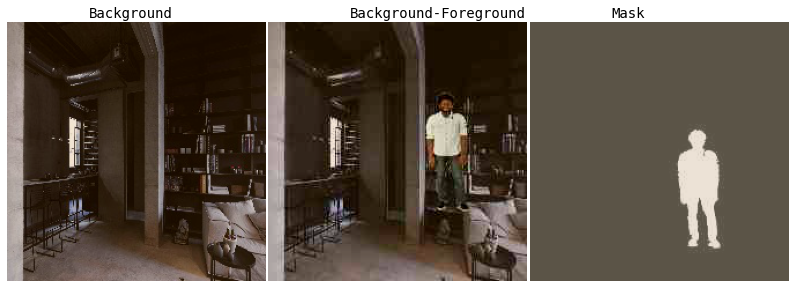

In [160]:
display_images(180,ax=plt)

In [26]:
trainLoader, testLoader = Data_To_Dataloader(train,test,batch_size=512)

In [ ]:
a,b = iter(trainLoader).next()

In [39]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim


class UNet(nn.Module):
    def contracting_block(self, in_channels, out_channels, kernel_size=3):
        """
        This function creates one contracting block consisting of 2 Convolution Blocks
        """
        block = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=out_channels),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(out_channels),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=out_channels, out_channels=out_channels),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(out_channels)
                )
        return block

    def expansive_block(self, in_channels, mid_channel, out_channels, kernel_size=3):
        """
        This function creates one expansive block consists of 3 Convolution Blocks with 2 being normal and 1 is ConvTranspose
        """
        block = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=mid_channel),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.ConvTranspose2d(in_channels=mid_channel, out_channels=out_channels, kernel_size=3, 
                    stride=2, padding=1, output_padding=1)) # upsampling part
        return  block

    def final_block(self, in_channels, mid_channel, out_channels, kernel_size=3):
        """
        This returns final block consists of 3 Convolution Blocks
        """
        block = torch.nn.Sequential(
                torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=mid_channel),
                torch.nn.ReLU(),
                torch.nn.BatchNorm2d(mid_channel),
                torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=mid_channel),
                torch.nn.ReLU(),
                torch.nn.BatchNorm2d(mid_channel),
                torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, out_channels=out_channels, padding=1),
                torch.nn.ReLU(),
                torch.nn.BatchNorm2d(out_channels),
                )
        return  block

    def __init__(self, in_channel, out_channel):
        super(UNet, self).__init__()

        #EnCode Block
        self.conv_encode1 = self.contracting_block(in_channels=in_channel, out_channels=64)
        self.conv_maxpool1 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv_encode2 = self.contracting_block(64, 128)
        self.conv_maxpool2 = torch.nn.MaxPool2d(kernel_size=2)
        self.conv_encode3 = self.contracting_block(128, 256)
        self.conv_maxpool3 = torch.nn.MaxPool2d(kernel_size=2)


        # Bottleneck
        self.bottleneck = torch.nn.Sequential(
                            torch.nn.Conv2d(kernel_size=3, in_channels=256, out_channels=512),
                            torch.nn.ReLU(),
                            torch.nn.BatchNorm2d(512),
                            torch.nn.Conv2d(kernel_size=3, in_channels=512, out_channels=512),
                            torch.nn.ReLU(),
                            torch.nn.BatchNorm2d(512),
                            torch.nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3,
                             stride=2, padding=1, output_padding=1))


        # DeCode Block
        self.conv_decode3 = self.expansive_block(512, 256, 128)
        self.conv_decode2 = self.expansive_block(256, 128, 64)
        self.final_layer = self.final_block(128, 64, out_channel)


    def crop_and_concat(self, upsampled, bypass, crop=False):
        """
        This layer crop the layer from contraction block and concat it with expansive block vector
        """
        if crop:
            c = (bypass.size()[2] - upsampled.size()[2]) // 2
            bypass = F.pad(bypass, (-c, -c, -c, -c))
        return torch.cat((upsampled, bypass), 1)


    def forward(self, x):
        # Encode
        encode_block1 = self.conv_encode1(x)
        encode_pool1 = self.conv_maxpool1(encode_block1)
        encode_block2 = self.conv_encode2(encode_pool1)
        encode_pool2 = self.conv_maxpool2(encode_block2)
        encode_block3 = self.conv_encode3(encode_pool2)
        encode_pool3 = self.conv_maxpool3(encode_block3)

        # Bottleneck
        bottleneck1 = self.bottleneck(encode_pool3)

        # Decode
        decode_block3 = self.crop_and_concat(bottleneck1, encode_block3, crop=True)
        cat_layer2 = self.conv_decode3(decode_block3)
        decode_block2 = self.crop_and_concat(cat_layer2, encode_block2, crop=True)
        cat_layer1 = self.conv_decode2(decode_block2)
        decode_block1 = self.crop_and_concat(cat_layer1, encode_block1, crop=True)
        final_layer = self.final_layer(decode_block1)
        return  final_layer




In [44]:
from torchsummary import summary
import torch
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
model = UNet(3,1).to(device)
summary(model, input_size=(3, 224, 224))

RuntimeError: ignored

In [ ]:
import torch.optim as optim
import torch.nn as nn
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-4, weight_decay=1e-2)


In [ ]:
from tqdm import tqdm
import numpy as np
import torch.nn.functional as F
import torch


class Test_Train():
  def __init__(self, model, device, optimizer, criterion, scheduler=True ):


    self.model = model
    self.device = device
    self.optimizer = optimizer
    self.criterion = criterion
    self.scheduler = scheduler

# # This is to hold all the values and plot some graphs to extract few good insights.
    self.train_losses = []
    self.test_losses = []
    self.train_acc = []
    self.test_acc = []
    self.train_epoch_end = []
    self.test_loss_min = np.inf # setting it to infinity(max value)
    # when the test loss becomes min I will save the particular model


  def train(self, trainloader, epoch):
    self.model.train()    # prepare model for training
    pbar = tqdm(trainloader)
    correct = 0
    processed = 0
    loss = 0
    for batch_idx, (data, target) in enumerate(pbar): # passing on data & target values to device
      data, target = data.to(self.device), target.to(self.device)
      self.optimizer.zero_grad()    # clear the gradients of all optimized variables

      # Predict
      y_pred = self.model(data)   # forward pass

      # Calculate loss
      loss = self.criterion(y_pred, target)

      # #Implementing L1 Regularization
      # if L1lambda:
      #   with torch.enable_grad():
      #     l1_loss = 0.
      #     for param in self.model.parameters():
      #       l1_loss += torch.sum(param.abs())
      #     loss = c_loss +  (L1lambda * l1_loss)



      # Backpropagation
      loss.backward()   # backward pass: compute gradient of the loss with respect to model parameters
      self.optimizer.step()   # perform a single optimization step (parameter update)
      # if self.scheduler:
      #   scheduler.step(loss)


      # Update pbar-tqdm
      pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += pred.eq(target.view_as(pred)).sum().item()
      processed += len(data)

      pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    self.train_acc.append(100*correct/processed)
    
    self.train_epoch_end.append(self.train_acc[-1])
    self.train_losses.append(loss)


  def test(self, testloader, filename, correct_samples, correctLabels, incorrect_samples):
      self.model.eval()  # prep model for evaluation
      test_loss = 0
      correct = 0

      with torch.no_grad(): # setting gradients back to zero
          for data, target in testloader:

            img_batch = data # this is done to store data
            data, target = data.to(self.device), target.to(self.device)

            # forward pass: compute predicted outputs by passing inputs to the model
            output = self.model(data)

            # sum up batch loss
            # test_loss += F.nll_loss(output, target, reduction='sum').item()
            test_loss = self.criterion(output, target).item()


            # get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

            # storing the entire result data as binary
            result = pred.eq(target.view_as(pred))
            # scheduler.step()

            # This is to extract incorrect samples/misclassified images
            if len(incorrect_samples) < 25:
              for i in range(0, testloader.batch_size):
                if not list(result)[i]:
                  incorrect_samples.append({'prediction': list(pred)[i], 'label': list(target.view_as(pred))[i],'image': img_batch[i]})


            # this is to extract correct samples/classified images
            if len(correct_samples) < 25:
              for i in range(0, testloader.batch_size):
                if list(result)[i]:
                  correct_samples.append({'prediction': list(pred)[i], 'label': list(target.view_as(pred))[i],'image': img_batch[i]})
                  correctLabels.append(list(target.view_as(pred))[i]) # this is for gradcam




      # save model if validation loss has decreased
      if test_loss <= self.test_loss_min:
          print('Validation loss has  decreased ({:.4f} --> {:.4f}).  Saving model ...'.format(self.test_loss_min,test_loss ))
          torch.save(self.model.state_dict(), filename)
          self.test_loss_min = test_loss


      print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
          test_loss, correct, len(testloader.dataset),
          100. * correct / len(testloader.dataset)))


      self.test_acc.append(100. * correct / len(testloader.dataset))
      self.test_losses.append(test_loss)



def cross_entropy_loss():
    """Returns:
        Cross entroy loss function
    """
    return torch.nn.CrossEntropyLoss()

def model_summary(model, input_size=(3,32,32)):
  """
  Returns Summary of the model passed in as model
  """
  return summary(model, input_size)



In [ ]:

model = ResNet18().to(device)
EPOCHS = 50
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum=0.95, nesterov = True) 
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr = 0.01, total_steps=31000, epochs = 50, steps_per_epoch=len(trainLoader),
                                                pct_start=0.5, anneal_strategy='linear', cycle_momentum=True, 
                                                base_momentum=0.85, max_momentum=0.95, div_factor=10, final_div_factor=1)


model1 = execute.Test_Train(model, device, optimizer, criterion, scheduler=True)



for epoch in range(1, EPOCHS+1):
  print('EPOCH: ',epoch)
  model1.train(trainLoader, epoch)
  scheduler.step()
  model1.test(testLoader, 'model1.pt', correctSamples, correctLabels, incorrectSamples)
  # scheduler.step(model1.test_losses[-1])
  for param_group in optimizer.param_groups:
    print('Learning Rate = {a} for EPOCH {e}'.format(a = round(param_group['lr'],5), e=epoch+1))
    learningRates.append(param_group['lr'])
  